# Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm

# Загружаем данные

In [2]:
train = pd.read_csv('03_santander_train.csv', index_col='ID')
train.shape

(76020, 370)

In [3]:
test = pd.read_csv('03_santander_test.csv', index_col='ID')
test.shape

(75818, 369)

In [4]:
y = list(train['TARGET'])
train = train.drop('TARGET', axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76020 entries, 1 to 151838
Columns: 369 entries, var3 to var38
dtypes: float64(111), int64(258)
memory usage: 214.6 MB


In [5]:
# Соеденим train и test в all_data
train['is_test'] = False
test['is_test'] = True
all_data = pd.concat([train, test])
all_data.shape

(151838, 370)

In [6]:
# выводим список всех фичей verbose=False - показывать весь список
train.info(verbose=False, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76020 entries, 1 to 151838
Columns: 370 entries, var3 to is_test
dtypes: bool(1), float64(111), int64(258)
memory usage: 214.7 MB


In [7]:
# Разделим снова all_data на train и test по ранее сделанным меткам
train = all_data[~all_data.is_test].drop(['is_test'], axis=1)
test = all_data[all_data.is_test].drop(['is_test'], axis=1)
train.shape

(76020, 369)

In [8]:
# Разобьем наш train датасет на train X_train и X_test
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=42)

# Вспомогательные функции

In [9]:
def draw_hist(_y, result_predicts, xlim=(-1, 15), ylim=(-0.01, 1.01), size=(5,10)):
    steps = []
    scores = []
    for data in result_predicts:
        predict_prob, step = data
        score = roc_auc_score(_y, predict_prob[:,1])
        steps.append(step)
        scores.append(score)
    
    plt.figure(figsize=size)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("steps")
    plt.ylabel("ROC_AUC")
    plt.bar(steps, scores)

In [10]:
def cal_predict(x_train, y_train, x_test, blackbox):
    """
    Строим модель прогнозирования
    
    @return predict, predict_proba 
    """
    model = blackbox # у квалификатора есть своё случайное значение.
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
    predict_proba = model.predict_proba(x_test)
    return predict, predict_proba

In [11]:
def draw_roc_auc_multy(y_test, result_predicts):
    plt.figure(figsize=(5, 6))
    plt.plot([0, 1], [0, 1])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.grid(True)
    plt.xlim((-0.01, 1.01))
    plt.ylim((-0.01, 1.01))
    for data in result_predicts:
        predict_prob, depth = data
        score = roc_auc_score(y_test, predict_prob[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, predict_prob[:,1])
        plt.plot(fpr, tpr, label=f'ROC {score:.3f} {depth}')
    plt.legend( borderaxespad=0.)

# Строим модель Дерево решений

In [12]:
dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train, y_train)
predict_dtc = dtc.predict(X_test)

print('precision', precision_score(y_test, predict_dtc))
print('recall', recall_score(y_test, predict_dtc))
print('accuracy', accuracy_score(y_test, predict_dtc))
print('f1', f1_score(y_test, predict_dtc))

precision 0.235294117647
recall 0.00403632694248
accuracy 0.960138717264
f1 0.00793650793651


In [13]:
predict_dtc = dtc.predict_proba(X_test)

(-0.01, 1.01)

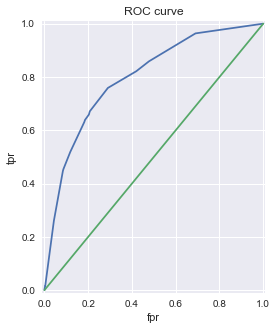

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
pic_dtc = fpr, tpr, thresholds = roc_curve(y_test, predict_dtc[:,1])
plt.figure(figsize=(4, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

# Подберем лучшие параметры модели (вопрос)

In [15]:
from sklearn.model_selection import GridSearchCV

In [56]:
dtc_params = {'max_depth': np.arange(1,11)} #'max_features' np. range(1,300)}

In [57]:
dtc_grid = GridSearchCV(dtc, dtc_params, cv=5, n_jobs=-1, verbose=True)
# n_jobs параллелим процессы

In [31]:
%%time
dtc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


Wall time: 1min 7s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [30]:
print('best_estimator', dtc_grid.best_estimator_)
print('best_score_', dtc_grid.best_score_)
print('best_params_',dtc_grid.best_params_)

best_estimator DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
best_score_ 0.960398955491
best_params_ {'max_depth': 1}


In [37]:
accuracy_score(y_train, dtc_grid.predict(X_train))

0.96039895549054644

# Визуализируем дерево

In [36]:
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz
from sklearn import tree
import pydot

#вариант1
dot_data = StringIO()  
tree.export_graphviz(dtc, out_file=dot_data,  
                     feature_names=train.columns,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  

Image(graph[0].create_png())

#вариант2
#dot_data = StringIO()
#export_graphviz(dtc, out_file=dot_data, feature_names=train.columns, filled=True)
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(value=graph.create_png())

FileNotFoundError: [WinError 2] "dot.exe" not found in path.

In [58]:
predict_probs=[]
for depth in tqdm(range(1,15,2)):
    blackbox = DecisionTreeClassifier(max_depth=depth, random_state=42)
    predict, predict_prob = cal_predict(
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        blackbox=blackbox
    )
    predict_probs.append((predict_prob, depth))

100%|████████████████████████████████████████████| 7/7 [00:12<00:00,  1.81s/it]


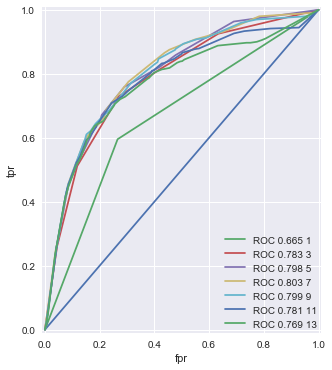

In [62]:
draw_roc_auc_multy(y_test, predict_probs)

# Кроссвалидация модели

In [16]:
from sklearn.cross_validation import cross_val_score
dtc = DecisionTreeClassifier()
print('10 Folds',cross_val_score(dtc, X_train, y_train, scoring='roc_auc', cv=10))
print('mean', np.mean(cross_val_score(dtc, X_train, y_train, scoring='roc_auc', cv=10)))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


10 Folds [ 0.59213011  0.57270711  0.57852991  0.57608957  0.56325846  0.5763537
  0.58341144  0.56826275  0.56760615  0.58395255]
mean 0.578529156889


# Строим модель KNeighborsClassifier

In [16]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
predict_knn = knn.predict(X_test)

In [17]:
print('precision', precision_score(y_test, predict_knn))
print('recall', recall_score(y_test, predict_knn))
print('accuracy', accuracy_score(y_test, predict_knn))
print('f1', f1_score(y_test, predict_knn))

precision 0.107709750567
recall 0.095862764884
accuracy 0.932913461155
f1 0.10144153764


In [18]:
predict_knn = knn.predict_proba(X_test)

(-0.01, 1.01)

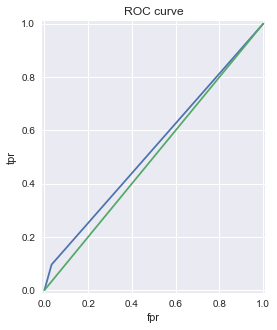

In [19]:
pic_knn = fpr, tpr, thresholds = roc_curve(y_test, predict_knn[:,1])
plt.figure(figsize=(4, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

# Строим модель LogisticRegression

In [21]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)
predict_lr = lr.predict(X_test)

In [22]:
print('precision', precision_score(y_test, predict_lr))
print('recall', recall_score(y_test, predict_lr))
print('accuracy', accuracy_score(y_test, predict_lr))
print('f1', f1_score(y_test, predict_lr))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


precision 0.0
recall 0.0
accuracy 0.960497468809


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 0.0


In [25]:
print('roc_auc_dtc', roc_auc_score(y_test, dtc.predict_dtc(X_test)[:,1]))
print('roc_auc_knn', roc_auc_score(y_test, knn.predict_knn(X_test)[:,1]))
print('roc_auc_lr', roc_auc_score(y_test, lr.predict_lr(X_test)[:,1]))

AttributeError: 'DecisionTreeClassifier' object has no attribute 'predict_dtc'

https://www.kaggle.com/cast42/exploring-features